$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 4: Classification with LDA and Logistic Regression

*Sean Russell*

## Overview

Within these pages I compare LDA and linear and nonlinear logistic regression applied to political science and botany.

## Python Implementations

These methods are used to easily determine the accuracy of neural networks and LDA by determining the percentage of accurately classified samples

In [1]:
%matplotlib inline 
import numpy as np
import neuralnetworks as nn
import qdalda as ql
import matplotlib.pyplot as plt
import csv

In [2]:
def trainLDA(X,T,parameters=None):
    #parameters value not used
    model = ql.LDA()
    model.train(X,T)
    return model

def evaluateLDA(model,X,T):
    calculated = model.use(X)[0]
    calculated = calculated.flatten()
    T = T.flatten()
    numberCorrect = np.sum(calculated == T)
    percentCorrect = numberCorrect / len(T) * 100
    return percentCorrect

def trainNN(X,T,parameters):
    inputSize = X.shape[1] # DIMENSIONS OF INPUT VECTORS
    outputSize = len(np.unique(T)) # NUMBER OF CLASSES
    nnet = nn.NeuralNetworkClassifier(inputSize,parameters[0],outputSize)
    nnet.train(X,T,nIterations = parameters[1])
    return nnet

def evaluateNN(model,X,T):
    calculated = model.use(X)
    numberCorrect = np.sum(calculated == T)
    percentCorrect = numberCorrect / len(T) * 100
    return percentCorrect

## Data

The first dataset examined with these algorithms is voting records from the 1984 house of representatives. Representatives voted yea or nay on 16 different issues, and their party affiliation was recorded. The goal then is to give each representative a party based on their voting history.

The second dataset deals with classifying irises based off of the dimensions of the flowers.

### Political Science

First, read in the data

In [3]:
with open('political/house-votes-84.data', 'r') as f:
    reader = csv.reader(f)
    poldata = list(reader)
representatives = {'republican':0,'democrat':1}
yn = {'n':-1,'?':0,'y':1}
for row in poldata:
    for index, item in enumerate(row):
        row[index] = representatives[item] if index == 0 else yn[item]
poldata = np.array(poldata)
polnames = ['handicapped infants','water project cost sharing','adoption of budget resolution',
            'physician fee freeze','el salvidor aid','religious groups in schools','anti satellite test ban',
            'aid to nicaraguan contras','mx missile','immigration','synfuels corporation cutback',
            'education spending','superfund right to sue','crime','duty free exports',
            'export administration act south africa']
poltargets = poldata[:,0,None]
polinputs = poldata[:,1:]

I then arranged the data into dictionaries based on the issue at hand, the way that representatives voted, and the party affiliation of the representatives.

In [4]:
partyVotingRecords = {}

for rep in representatives:
    for issue in range(polinputs.shape[1]):
        repIssues = polinputs[poltargets[:,0]==representatives[rep]][:,issue]
        yea = np.count_nonzero(repIssues == 1)
        nay = np.count_nonzero(repIssues == -1)
        unknown = np.count_nonzero(repIssues == 0)
        partyVotingRecords[rep + ' ' + polnames[issue] + ' yea'] = yea
        partyVotingRecords[rep + ' ' + polnames[issue] + ' nay'] = nay
        partyVotingRecords[rep + ' ' + polnames[issue] + ' unknown'] = unknown
partyVotingRecords

{'democrat adoption of budget resolution nay': 29,
 'democrat adoption of budget resolution unknown': 7,
 'democrat adoption of budget resolution yea': 231,
 'democrat aid to nicaraguan contras nay': 45,
 'democrat aid to nicaraguan contras unknown': 4,
 'democrat aid to nicaraguan contras yea': 218,
 'democrat anti satellite test ban nay': 59,
 'democrat anti satellite test ban unknown': 8,
 'democrat anti satellite test ban yea': 200,
 'democrat crime nay': 167,
 'democrat crime unknown': 10,
 'democrat crime yea': 90,
 'democrat duty free exports nay': 91,
 'democrat duty free exports unknown': 16,
 'democrat duty free exports yea': 160,
 'democrat education spending nay': 213,
 'democrat education spending unknown': 18,
 'democrat education spending yea': 36,
 'democrat el salvidor aid nay': 200,
 'democrat el salvidor aid unknown': 12,
 'democrat el salvidor aid yea': 55,
 'democrat export administration act south africa nay': 12,
 'democrat export administration act south africa 

I made another dictionary to make it even easier to access information, by first looking at the issue at hand, and then easily being able to view how the parties voted.

In [5]:
allIssues = {}
for vote in polnames:
    issue = {}
    for record in partyVotingRecords:
        if vote in record:
            issue[record.replace(vote + ' ','')] = partyVotingRecords[record]
            #print(vote,record)
    allIssues[vote] = issue
allIssues

{'adoption of budget resolution': {'democrat nay': 29,
  'democrat unknown': 7,
  'democrat yea': 231,
  'republican nay': 142,
  'republican unknown': 4,
  'republican yea': 22},
 'aid to nicaraguan contras': {'democrat nay': 45,
  'democrat unknown': 4,
  'democrat yea': 218,
  'republican nay': 133,
  'republican unknown': 11,
  'republican yea': 24},
 'anti satellite test ban': {'democrat nay': 59,
  'democrat unknown': 8,
  'democrat yea': 200,
  'republican nay': 123,
  'republican unknown': 6,
  'republican yea': 39},
 'crime': {'democrat nay': 167,
  'democrat unknown': 10,
  'democrat yea': 90,
  'republican nay': 3,
  'republican unknown': 7,
  'republican yea': 158},
 'duty free exports': {'democrat nay': 91,
  'democrat unknown': 16,
  'democrat yea': 160,
  'republican nay': 142,
  'republican unknown': 12,
  'republican yea': 14},
 'education spending': {'democrat nay': 213,
  'democrat unknown': 18,
  'democrat yea': 36,
  'republican nay': 20,
  'republican unknown': 13

Using this dictionary, I generated bar charts of every vote to see how representatives voted

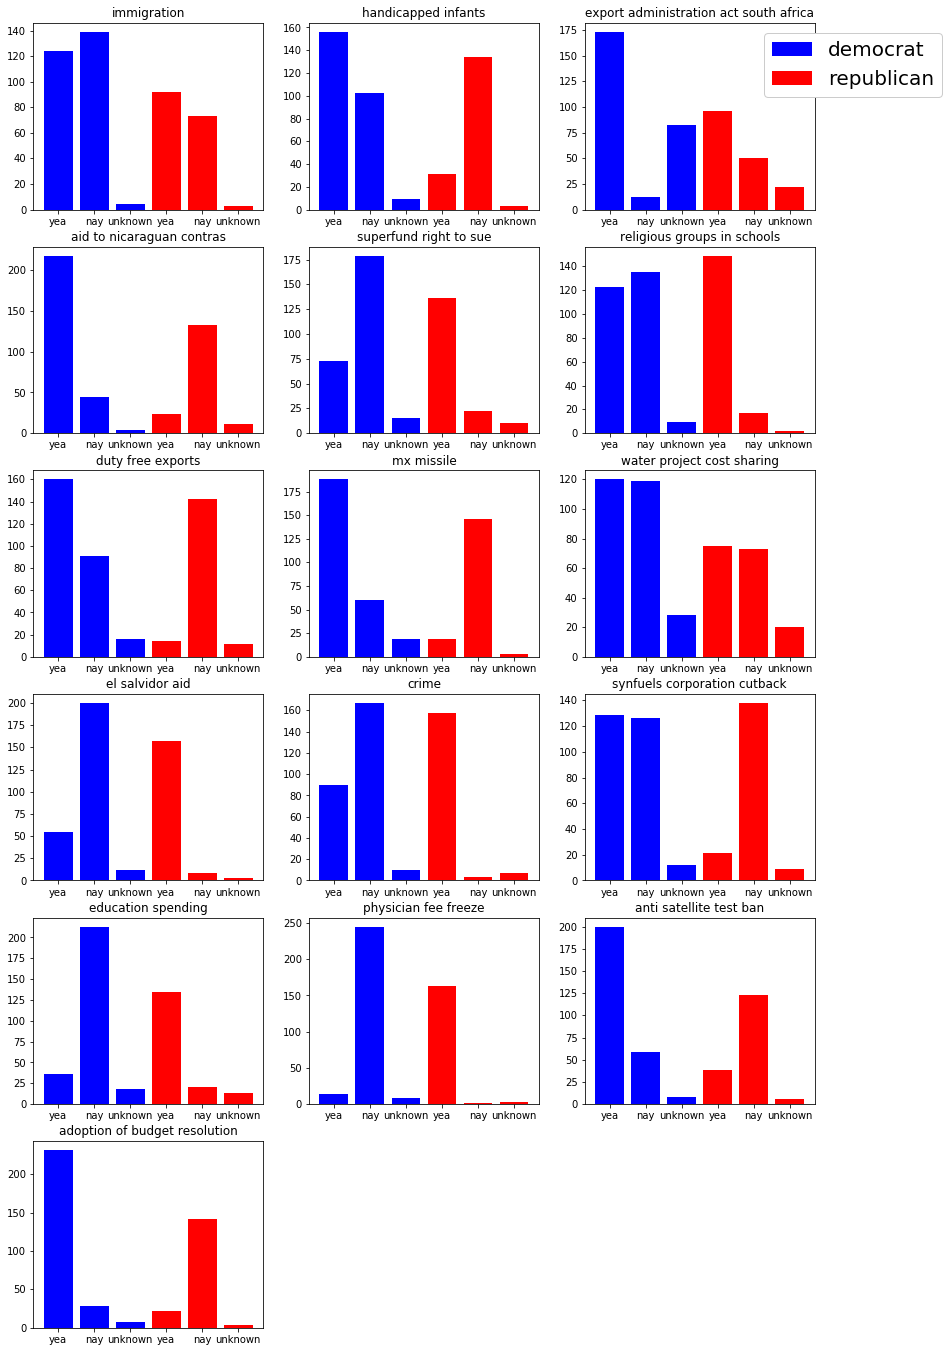

In [6]:
plt.rcParams["figure.figsize"] = [14.0,24.0]

for issue,i in zip(allIssues,range(len(allIssues))):
    ax = plt.subplot(6,3, i+1)
    demlabels, demdata, replabels, repdata = [], [], [], []
    for vote in allIssues[issue]:
        if 'democrat' in vote:
            demlabels.append(vote.replace('democrat ',''))
            demdata.append(allIssues[issue][vote])
        if 'republican' in vote:
            replabels.append(vote.replace('republican ',''))
            repdata.append(allIssues[issue][vote])
    demyeaindex = demlabels.index('yea')
    demneaindex = demlabels.index('nay')
    demunknownindex = demlabels.index('unknown')
    repyeaindex = replabels.index('yea')
    repneaindex = replabels.index('nay')
    repunknownindex = replabels.index('unknown')
    demlabels = [demlabels[demyeaindex],demlabels[demneaindex],demlabels[demunknownindex]]
    demdata = [demdata[demyeaindex],demdata[demneaindex],demdata[demunknownindex]]
    replabels = [replabels[repyeaindex],replabels[repneaindex],replabels[repunknownindex]]
    repdata = [repdata[repyeaindex],repdata[repneaindex],repdata[repunknownindex]]
    plt.bar([0,1,2], demdata,color='b',label='democrat')
    plt.bar([3,4,5], repdata,color='r',label='republican')
    plt.xticks([0,1,2,3,4,5], demlabels + replabels)
    plt.title(issue);

plt.legend(bbox_to_anchor=(4, 7),prop={'size':20}).get_frame().set_alpha(1);

There are a few interesting things that come to light after examining these charts. First, there are many more democrats than republicans. Second, republicans are more unified than democrats on most issues. Maybe republicans are more unified than democrats because they are in the minority, and so to have influence must work together? Also of note, democrats and republicans almost always vote opposite of one another (although this is not very suprising). Water project cost sharing and to a lesser degree imigration seem to be the only two issues where representatives are not strictly divided down party lines.

Using the methods defined above

In [7]:
ldaModel = trainLDA(polinputs,poltargets)
nnModel = trainNN(polinputs,poltargets,[[5],100])
print ('LDA accuracy:',evaluateLDA(ldaModel,polinputs,poltargets))
print ('Neural network accuracy:',evaluateNN(nnModel,polinputs,poltargets))

LDA accuracy: 95.632183908
Neural network accuracy: 100.0


Accuracy is extremely high, likely due to the limited number of classes (only democrat and republican) and the extreme degree to which politicans vote along party lines

### Iris

The sepal and petal of an iris are displayed in this image:


![Image of Iris](https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg)

The second dataset involves catagorizing iris flowers into one of three subspecies: setosa, versicolor, or virignica, based of of the dimensions of the sepal and the petal.
First things first, read in the data:

In [8]:
with open('iris/iris.data', 'r') as f:
    reader = csv.reader(f)
    irisdata = list(reader)
irisdata = irisdata[:-1]
classes = {'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2}
for row in irisdata:
    for index,item in enumerate(row):
        row[index] = classes[item] if index == 4 else float(item)
irisdata = np.array(irisdata)
irisnames = ['sepal length','sepal width','petal length','petal width']
iristargets = irisdata[:,4,None]
irisinputs = irisdata[:,:4]

And then I tried splitting the data up based on the type of flower

In [9]:
iris_setosa = irisdata[irisdata[:,4]==0][:,:4]
iris_versicolor = irisdata[irisdata[:,4]==1][:,:4]
iris_virginica = irisdata[irisdata[:,4]==2][:,:4]

After doing this, we can see the means of the data by flower type

In [10]:
print(irisnames)
print('setosa:\t\t',iris_setosa.mean(axis=0))
print('versicolor:\t',iris_versicolor.mean(axis=0))
print('virginica:\t',iris_virginica.mean(axis=0))

['sepal length', 'sepal width', 'petal length', 'petal width']
setosa:		 [ 5.006  3.418  1.464  0.244]
versicolor:	 [ 5.936  2.77   4.26   1.326]
virginica:	 [ 6.588  2.974  5.552  2.026]


The setosa has a much smaller petals than the other two, while its sepal length is mostly the same. This will probably be a significant factor in determining if the flower is a setosa. Virginica tends to be bigger than versicolor, but the relative dimensions seem fairly similar. Classification algorithms might find trouble in distinguishing the two.
Next I tried plotting the values of the different irises to see what could be seen

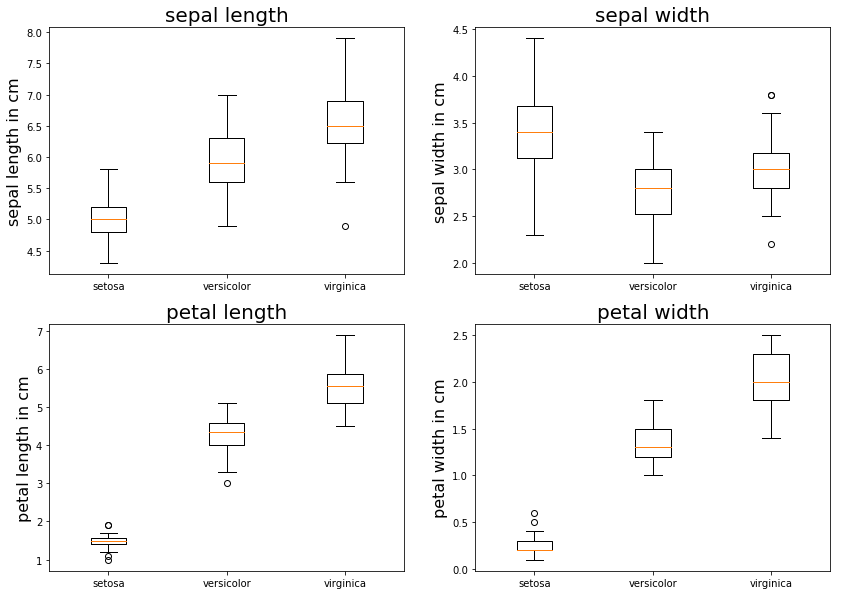

In [11]:
plt.rcParams["figure.figsize"] = [14.0,10.0]

for i in range(4):
    setosa_i = iris_setosa[:,i]
    versicolor_i = iris_versicolor[:,i]
    virginica_i = iris_virginica[:,i]
    data_i = [setosa_i, versicolor_i, virginica_i]
    plt.subplot(2,2,i+1)
    plt.boxplot(data_i,labels = ['setosa','versicolor','virginica'])
    plt.title(irisnames[i],fontsize = 20)
    #plt.xticks([1,2,3], ['setosa','versicolor','virginica'])
    plt.ylabel(irisnames[i] + ' in cm', fontsize = 16)


Setosa iris has very little variance when it comes to petals, and since the petals are so different in size than in the other two this is probably the best way to determine whether or not an iris is a setosa. In general, versicolor and virginica are fairly similar, however virginica tends to be larger than versicolor as noted earlier. Since there is a large degree of overlap it will likely be very difficult for the algorithms to choose between the two.

In [12]:
ldaModel = trainLDA(irisinputs,iristargets)
nnModel = trainNN(irisinputs,iristargets,[[5],100])
print ('LDA accuracy:',evaluateLDA(ldaModel,irisinputs,iristargets))
print ('Neural network accuracy:',evaluateNN(nnModel,irisinputs,iristargets))

LDA accuracy: 98.0
Neural network accuracy: 99.3333333333


The accuracy is higher than I anticipated. Of course since the classifier only needs to choose between three classes the problem is somewhat easier. In addition, the relatively small sample size of only 150 irises makes this especially suceptible to overfitting. To get a more accurate sense of the predictive powers of these models I would need a larger sample size and would also need to split the data into train and verification segments.

In [13]:
ldaModel = trainLDA(irisinputs,iristargets)
nnModel = trainNN(irisinputs,iristargets,[[0],100])
print ('LDA accuracy:',evaluateLDA(ldaModel,irisinputs,iristargets))
print ('Neural network accuracy:',evaluateNN(nnModel,irisinputs,iristargets))

LDA accuracy: 98.0
Neural network accuracy: 98.0


Just for fun I ran the neural network with zero hidden layers. It produced the same results as the linear classifier, which is what I expected.

## Conclusions

For both the political science and iris datasets, the neural network and LDA algorithms had extremely high accuracy. The neural networks performed slightly better, in both cases approching 100% accuracy. This is likely due to the limited number of classes in both datasets as well as the fairly well defined boundaries in the datasets.

## Check-in

In [14]:
%run -i A4grader.py


   Testing   model = trainLDA(X,T)
             accuracy = evaluateLDA(model,X,T)

20/20 points. Accuracy is within 10 of correct value 50%

   Testing   model = trainNN(X,T, [[5],100])
             accuracy = evaluateNN(model,X,T)

30/30 points. Accuracy is within 10 of correct value 100%

  Testing
    resultsNN = ml.trainValidateTestKFoldsClassification( trainNN,evaluateNN, X,T, 
                                                          [ [ [0], 5], [ [10], 100] ],
                                                          nFolds=3, shuffle=False,verbose=False)
    bestParms = [row[0] for row in resultsNN]


30/30 points. You correctly find the best parameters to be [[10],100] for each fold.

A4 CODING GRADE is 80/80

A4 WRITING GRADE is ??/20

A4 FINAL GRADE is ??/100

Remember, this python script is just an example of how your code will be graded.
Do not be satisfied with an 80% from running this script.  Write and run additional
tests of your own design.
